In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [8]:
df_regression = pd.read_csv("../dataset/created/df_regression.csv")

## 6. Apply analysis technique: Regression models

### * Functions to regression models

In [9]:
def perform_linear_regression(df, dependent_var, independent_vars):
    """
    Realiza uma regressão linear e imprime os resultados.

    Args:
        df (pd.DataFrame): O DataFrame de entrada.
        dependent_var (str): Nome da variável dependente (numérica).
        independent_vars (list): Lista de nomes das variáveis independentes.

    Returns:
        statsmodels.regression.linear_model.RegressionResultsWrapper: O objeto de resultados da regressão, ou None se a regressão não puder ser realizada.
    """
    print(f"\n--- Regressão Linear para {dependent_var} ---")

    df_model = df[[dependent_var] + independent_vars].dropna()

    if df_model.empty:
        print("⚠️ DataFrame vazio após remover NaNs. Não é possível realizar a regressão linear.")
        return

    X = df_model[independent_vars]
    y = df_model[dependent_var]

    X = sm.add_constant(X)

    model = sm.OLS(y, X)
    results = model.fit()

    print(results.summary())

    return results

In [10]:
def perform_logistic_regression(df, dependent_var, independent_vars, threshold=0.5):
    """
    Realiza uma regressão logística e imprime os resultados.

    Args:
        df (pd.DataFrame): O DataFrame de entrada.
        dependent_var (str): Nome da variável dependente (binária, 0 ou 1).
        independent_vars (list): Lista de nomes das variáveis independentes.
        threshold (float): Limiar para classificação binária.
    
    Returns:
        tuple: (statsmodels.regression.linear_model.RegressionResultsWrapper, pd.Series, np.ndarray)
               Contém o objeto de resultados da regressão, os valores reais (y) e as probabilidades previstas (y_pred_proba).
               Retorna (None, None, None) se a regressão não puder ser realizada.
    """
    print(f"\n--- Regressão Logística para {dependent_var} ---")

    df_model = df[[dependent_var] + independent_vars].dropna()

    if df_model.empty:
        print("⚠️ DataFrame vazio após remover NaNs. Não é possível realizar a regressão logística.")
        return

    X = df_model[independent_vars]
    y = df_model[dependent_var]

    X = sm.add_constant(X)

    model = sm.Logit(y, X)
    results = model.fit()

    print(results.summary())

    y_pred_proba = results.predict(X)
    y_pred = (y_pred_proba >= threshold).astype(int)

    print("\nMatriz de Confusão:")
    print(confusion_matrix(y, y_pred))

    print("\nRelatório de Classificação:")
    print(classification_report(y, y_pred))

    try:
        roc_auc = roc_auc_score(y, y_pred_proba)
        print(f"AUC-ROC: {roc_auc:.4f}")
    except ValueError:
        print("⚠️ Não foi possível calcular AUC-ROC (apenas uma classe presente na variável dependente).")
    
    return results, y, y_pred, y_pred_proba

### b. Linear regression

In [11]:
dependent_var_linear = "DEP_DELAY"
independent_vars_linear = [
    "DISTANCE",
    "AIR_TIME",
    "DAY_OF_WEEK_NUM",
    "TIME_OF_DAY_NUM",
] + [col for col in df_regression.columns if col.startswith("AIRLINE_")]

independent_vars_linear = [col for col in independent_vars_linear if col in df_regression.columns]

results_linear = perform_linear_regression(df_regression, dependent_var_linear, independent_vars_linear)

print(results_linear)


--- Regressão Linear para DEP_DELAY ---
                            OLS Regression Results                            
Dep. Variable:              DEP_DELAY   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     494.5
Date:                Thu, 25 Sep 2025   Prob (F-statistic):               0.00
Time:                        19:08:43   Log-Likelihood:            -2.8559e+06
No. Observations:              527197   AIC:                         5.712e+06
Df Residuals:                  527178   BIC:                         5.712e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

### c. Logistic regression

In [12]:
df_regression["IS_DELAYED_15MIN"] = (df_regression["DEP_DELAY"] > 15).astype(int)

dependent_var_logistic_name = "IS_DELAYED_15MIN"
independent_vars_logistic = [
    "DISTANCE",
    "DAY_OF_WEEK_NUM",
    "TIME_OF_DAY_NUM",
] + [col for col in df_regression.columns if col.startswith("AIRLINE_")]

independent_vars_logistic = [col for col in independent_vars_logistic if col in df_regression.columns]

results_logistic, y_true, y_pred, y_pred_proba = perform_logistic_regression(
    df_regression, dependent_var_logistic_name, independent_vars_logistic
)
print(results_logistic)


--- Regressão Logística para IS_DELAYED_15MIN ---
Optimization terminated successfully.
         Current function value: 0.475258
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:       IS_DELAYED_15MIN   No. Observations:               538836
Model:                          Logit   Df Residuals:                   538818
Method:                           MLE   Df Model:                           17
Date:                Thu, 25 Sep 2025   Pseudo R-squ.:                 0.05176
Time:                        19:08:47   Log-Likelihood:            -2.5609e+05
converged:                       True   LL-Null:                   -2.7006e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const            

### d. Displaying the results

#### Gráfico de Odds Ratios

C:\Users\Vitoria\AppData\Local\Temp\ipykernel_32392\681768900.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefs.index, y=coefs.values, palette='viridis')


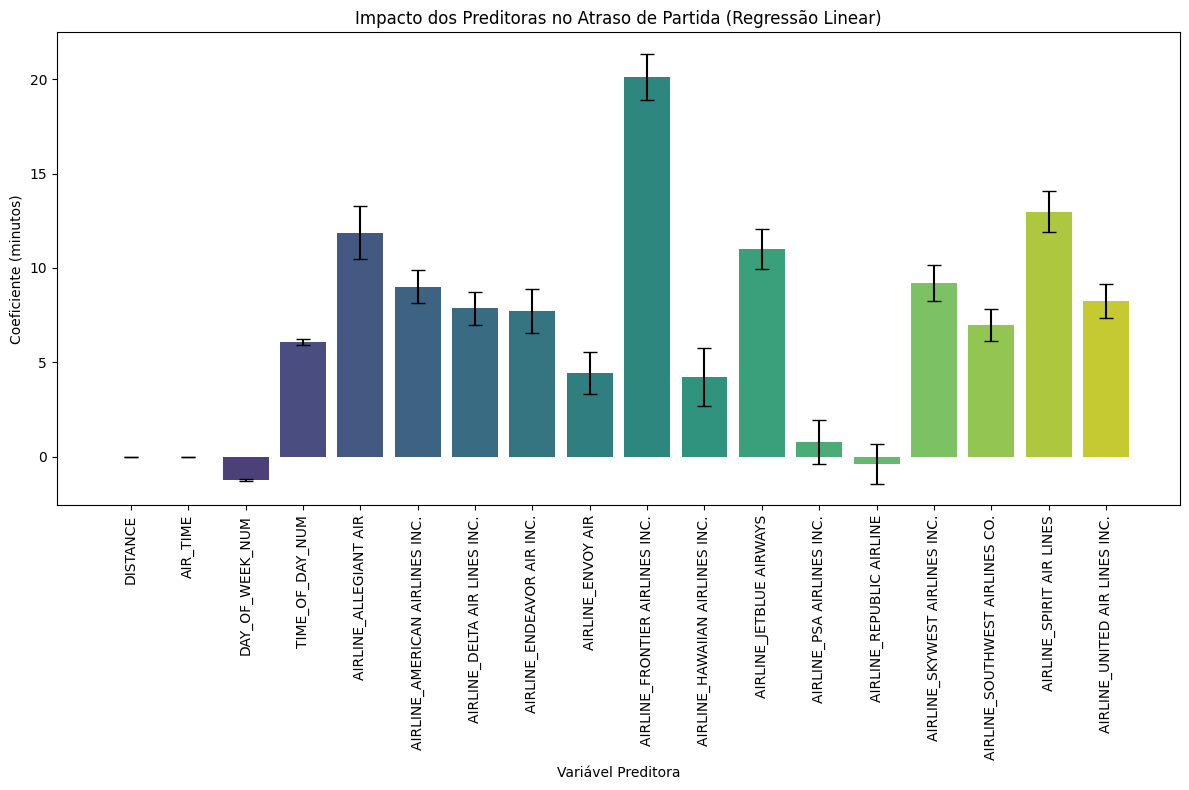

In [13]:
coefs = results_linear.params.drop('const')
conf_int = results_linear.conf_int().drop('const')
errors = (conf_int[1] - conf_int[0]) / 2

plt.figure(figsize=(12, 8))
sns.barplot(x=coefs.index, y=coefs.values, palette='viridis')
plt.errorbar(x=coefs.index, y=coefs.values, yerr=errors, fmt='none', c='black', capsize=5)
plt.xticks(rotation=90)
plt.title('Impacto dos Preditoras no Atraso de Partida (Regressão Linear)')
plt.ylabel('Coeficiente (minutos)')
plt.xlabel('Variável Preditora')
plt.tight_layout()
plt.show()


C:\Users\Vitoria\AppData\Local\Temp\ipykernel_32392\1639382792.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=odds_ratios.index, y=odds_ratios.values, palette='coolwarm')


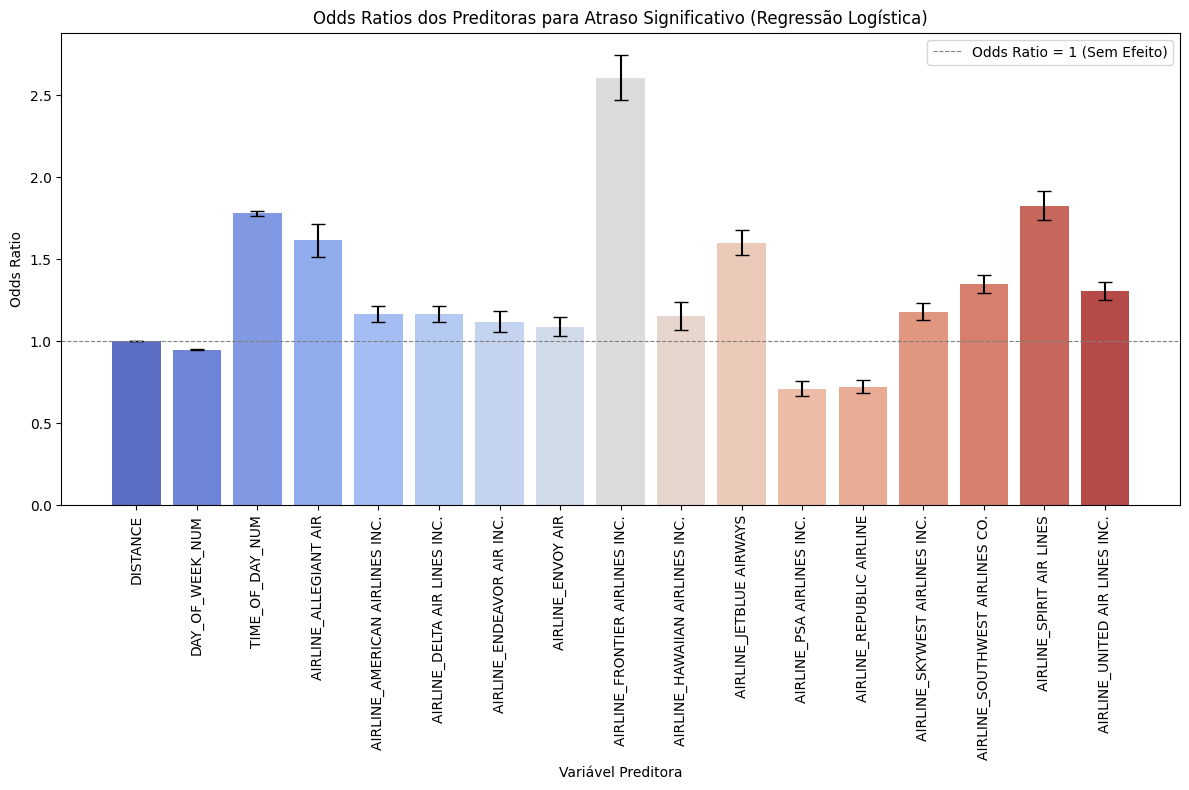

In [14]:
odds_ratios = np.exp(results_logistic.params.drop('const'))
conf_int_odds = np.exp(results_logistic.conf_int().drop('const'))
errors_odds = (conf_int_odds[1] - conf_int_odds[0]) / 2

plt.figure(figsize=(12, 8))
sns.barplot(x=odds_ratios.index, y=odds_ratios.values, palette='coolwarm')
plt.errorbar(x=odds_ratios.index, y=odds_ratios.values, yerr=errors_odds, fmt='none', c='black', capsize=5)
plt.axhline(1, color='gray', linestyle='--', linewidth=0.8, label='Odds Ratio = 1 (Sem Efeito)')
plt.xticks(rotation=90)
plt.title('Odds Ratios dos Preditoras para Atraso Significativo (Regressão Logística)')
plt.ylabel('Odds Ratio')
plt.xlabel('Variável Preditora')
plt.legend()
plt.tight_layout()
plt.show()


#### Curva ROC

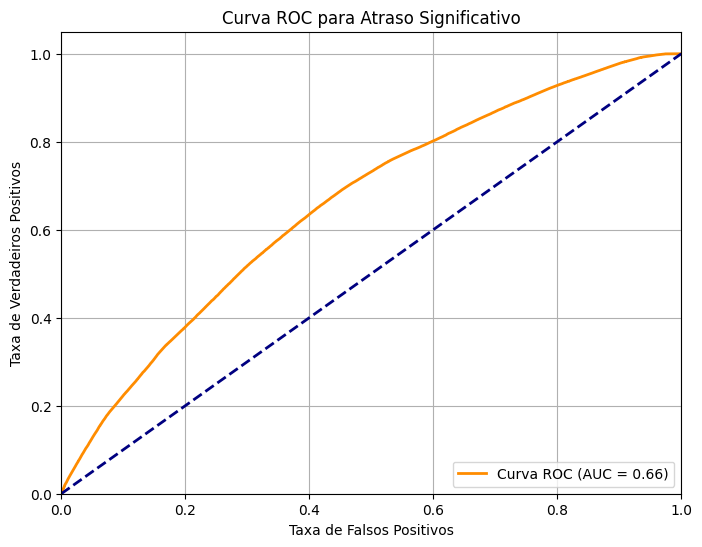

In [15]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
auc = roc_auc_score(y_true, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC para Atraso Significativo')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


#### Heatmap da Matriz de Confusão

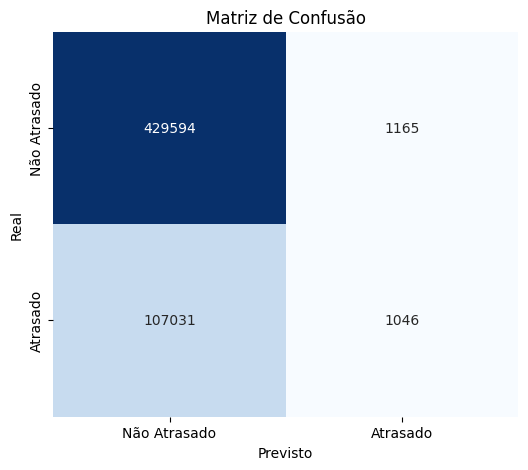

In [16]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Não Atrasado', 'Atrasado'],
            yticklabels=['Não Atrasado', 'Atrasado'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()
